 # Nuclei Localization using UNET

## Dependencies

In [52]:
import glob
import time
import os

import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

## Data Engineering

### Importing Training and Testing images using cv2

In [3]:
train_path = "data-science-bowl-2018\stage1_train"
all_trains = os.listdir(train_path)
test_path = "data-science-bowl-2018\stage1_test"
all_tests = os.listdir(test_path)
img_size = 128

train_img = []
for each_train in tqdm(all_trains):
    each_train_img = os.path.join(train_path, each_train, "images", each_train + ".png")
    each_train_img = cv2.imread(each_train_img, 1)
    each_train_img = cv2.resize(each_train_img, (img_size, img_size))
    train_img.append(each_train_img)
print('Done importing training images')
    
test_img = []
for each_test in tqdm(all_tests):
    each_test_img = os.path.join(test_path, each_test, "images", each_test + ".png")
    each_test_img = cv2.imread(each_test_img, 1)
    each_test_img = cv2.resize(each_test_img, (img_size, img_size))
    test_img.append(each_test_img)
print('Done importing testing images')

  3%|██▌                                                                                | 2/65 [00:00<00:03, 19.94it/s]

Done importing training images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 37.15it/s]

Done importing testing images


### Creating masks for the training set

In [4]:
masks_per_train = []
for each_train in tqdm(all_trains):
    mask_path = os.path.join(train_path, each_train, "masks")
    mask_names = os.listdir(mask_path)
    mask = np.zeros((img_size, img_size, 1))
    for each_mask in mask_names:
        each_mask_path = os.path.join(mask_path, each_mask)
        mask_image = cv2.imread(each_mask_path, -1)
        mask_image = cv2.resize(mask_image, (img_size, img_size))
        mask_image = np.expand_dims(mask_image, axis=-1)
        mask = np.maximum(mask, mask_image)
    masks_per_train.append(mask)

100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [03:18<00:00,  3.38it/s]


### Normalizing

In [5]:
X_train = np.array(train_img)/255.0
y_train = np.array(masks_per_train)/255.0

print(X_train.shape)
print(y_train.shape)

## Model

### HyperParameters

In [ ]:
epochs = 10
batch_size = 8
filters = [64, 128, 256, 512, 1024]
kernel_size = (3,3)
input_shape = (img_size, img_size, 3)
optimizer = 'adam'
loss = "binary_crossentropy"

#### Defining The Model

In [8]:
def UNet():
    inputs = keras.layers.Input((img_size, img_size, 3))
    
    l0 = inputs
    c0 = Conv2D(filters=filters[0], kernel_size=kernel_size, padding='same', activation='relu')(l0)
    c0 = Conv2D(filters=filters[0], kernel_size=kernel_size, padding='same', activation='relu')(c0)
    p0 = MaxPooling2D(pool_size=(2,2), padding="same")(c0)

    c1 = Conv2D(filters=filters[1], kernel_size=kernel_size, padding='same', activation='relu')(p0)
    c1 = Conv2D(filters=filters[1], kernel_size=kernel_size, padding='same', activation='relu')(c1)
    p1 = MaxPooling2D(pool_size=(2,2), padding="same")(c1)
    
    c2 = Conv2D(filters=filters[2], kernel_size=kernel_size, padding='same', activation='relu')(p1)
    c2 = Conv2D(filters=filters[2], kernel_size=kernel_size, padding='same', activation='relu')(c2)
    p2 = MaxPooling2D(pool_size=(2,2), padding="same")(c2)
    
    c3 = Conv2D(filters=filters[3], kernel_size=kernel_size, padding='same', activation='relu')(p2)
    c3 = Conv2D(filters=filters[3], kernel_size=kernel_size, padding='same', activation='relu')(c3)
    p3 = MaxPooling2D(pool_size=(2,2), padding="same")(c3)
    
    b0 = Conv2D(filters=filters[4], kernel_size=kernel_size, padding='same', activation="relu")(p3)
    b0 = Conv2D(filters=filters[4], kernel_size=kernel_size, padding='same', activation="relu")(b0)
    
    u0 = UpSampling2D((2, 2))(b0)
    co0 = Concatenate()([u0, c3])
    c4 = Conv2D(filters=filters[3], kernel_size=kernel_size, padding='same', activation="relu")(co0)
    c4 = Conv2D(filters=filters[3], kernel_size=kernel_size, padding='same', activation="relu")(c4)
    
    u1 = UpSampling2D((2, 2))(c4)
    co1 = Concatenate()([u1, c2])
    c5 = Conv2D(filters=filters[2], kernel_size=kernel_size, padding='same', activation="relu")(co1)
    c5 = Conv2D(filters=filters[2], kernel_size=kernel_size, padding='same', activation="relu")(c5)
    
    u2 = UpSampling2D((2, 2))(c5)
    co2 = Concatenate()([u2, c1])
    c6 = Conv2D(filters=filters[1], kernel_size=kernel_size, padding='same', activation="relu")(co2)
    c6 = Conv2D(filters=filters[1], kernel_size=kernel_size, padding='same', activation="relu")(c6)
    
    u3 = UpSampling2D((2, 2))(c6)
    co3 = Concatenate()([u3, c0])
    c7 = Conv2D(filters=filters[0], kernel_size=kernel_size, padding='same', activation="relu")(co3)
    c7 = Conv2D(filters=filters[0], kernel_size=kernel_size, padding='same', activation="relu")(c7)
    
    outputs = Conv2D(1,(1,1), activation='sigmoid')(c7)
    model = Model(inputs, outputs)
    return model

### Compiling the graphs to the model

In [9]:
model = UNet()
model.compile(optimizer=optimizer, loss=loss, metrics=["acc"])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

### Training Step

In [180]:
model.fit(X_train, y_train, batch_size = 8, epochs = 5)

Epoch 1/5
84/84 [==============================] - 31s 364ms/step - loss: 0.7680 - acc: 0.8508
Epoch 2/5
84/84 [==============================] - 28s 338ms/step - loss: 0.1464 - acc: 0.9282
Epoch 3/5
84/84 [==============================] - 28s 339ms/step - loss: 0.1063 - acc: 0.9429
Epoch 4/5
84/84 [==============================] - 28s 339ms/step - loss: 0.1511 - acc: 0.9323
Epoch 5/5
84/84 [==============================] - 30s 354ms/step - loss: 0.1200 - acc: 0.9382


### Saving the weights

In [181]:
model.save_weights("weights/UNetW_1.h5")

### Loading weights

In [19]:
model.load_weights('weights/UNetW_1.h5')

## Testing

### Importing test images

In [45]:
test2_path = "data-science-bowl-2018\stage2_test_final"
all_tests2 = os.listdir(test_path)

test2_img = []
for each_test in tqdm(all_tests2):
    each_test_img = os.path.join(test_path, each_test, "images", each_test + ".png")
    each_test_img = cv2.imread(each_test_img, 1)
    each_test_img = cv2.resize(each_test_img, (img_size, img_size))
    test2_img.append(each_test_img)
print('Done importing testing images')

100%|█████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 252.58it/s]

Done importing testing images


### Predicting step

In [49]:
x = [np.array(test2_img[54])/255.0]
x = np.array(x)
print(x.shape)


result = model.predict(x)
result = result > 0.5

(1, 128, 128, 3)


### Comparing the prediction with image

(1, 128, 128, 3)


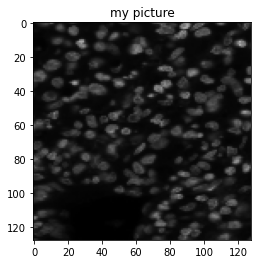

In [50]:
print(x.shape)
plt.imshow(x[0])
plt.title('my picture')
plt.show()

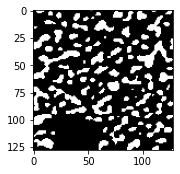

In [51]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255.0, (img_size, img_size)), cmap="gray")